In [1]:
import numpy as np
from desispec.io import read_spectra
from desispec.interpolation import resample_flux
from glob import glob
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

In [2]:
def rescale_flux(flux):
    """Rescale flux so that it ranges from 0 to 1.
    Parameters
    ----------
    flux : ndarray
        Input flux array.
    Returns
    -------
    rsfl : ndarray
        Flux rescaled to range between 0 and 1.
    """

    if flux.ndim > 1:
        a, b = np.min(flux,axis=1)[:,None], np.max(flux,axis=1)[:,None]
    else:
        a, b = np.min(flux), np.max(flux)
    
    return (flux - a) / (b - a)

In [3]:
def rebin_flux(wave, flux, ivar=None, z=None, minwave=3600., maxwave=9800., nbins=600, log=False, clip=False):
    """Rebin differential flux vs wavelength using desispec resample_flux.
    Parameters
    ----------
    wave : ndarray
        Input wavelength; assume units of Angstroms.
    flux : ndarray
        Input differential spectra as a function of wavelength.
    ivar : None or ndarray
        Inverse variance (weight) of spectra vs wavelength.
    z : None, float, or ndarray
        Known or estimated redshift(s) for input spectra.
    minwave : float
        Minimum output wavelength, in units of Angstroms.
    maxwave : float
        Maximum output wavelength, in units of Angstroms.
    nbins : int
        Number of output wavelength bins.
    log : bool
        If true, use logarithmic bins between minwave and maxwave.
    clip : bool
        If true, clip input values below zero before rescaling.
    Returns
    -------
    basewave : ndarray
        Output wavelength, in units of Angstroms.
    fl : ndarray
        Rebinned spectra.
    iv : ndarray
        Rebinned inverse variance.
    """
    # Choose new binning.
    if log:
        basewave = np.logspace(np.log10(minwave), np.log10(maxwave), nbins)
    else:
        basewave = np.linspace(minwave, maxwave, nbins)

    # Shift to rest frame.
    if z is not None:
        wave = wave/(1+z) if np.isscalar(z) else np.outer(1./(1+z), wave)

    if flux.ndim > 1:
        # Remove spectra with NaNs and zero flux values.
        mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
        mask_idx = np.argwhere(mask)
        flux = np.delete(flux, mask_idx, axis=0)
        ivar = np.delete(ivar, mask_idx, axis=0)
        if wave.ndim > 1:
            wave = np.delete(wave, mask_idx, axis=0)

        nspec = len(flux)
        fl = np.zeros((nspec, nbins))
        iv = np.ones((nspec, nbins))
        for i in range(nspec):
            # Wavelength array may be different for each input flux, e.g., if
            # we shift to the rest frame.
            wave_ = wave[i] if wave.ndim > 1 else wave

            if ivar is not None:
                fl[i], iv[i] = resample_flux(basewave, wave_, flux[i], ivar[i])
            else:
                fl[i] = resample_flux(basewave, wave_, flux[i])
    else:
        resampled = resample_flux(basewave, wave, flux, ivar)
        if ivar is not None:
            fl, iv = resampled
        else:
            fl, iv = resampled, None

    # Enable clipping of negative values.
    if clip:
        fl = fl.clip(min=0)

    return basewave, fl, iv

In [6]:
def condition_spectra(coadd_files, truth_files):
    """Read DESI spectra, rebin to a subsampled logarithmic wavelength grid, and rescale.
    
    Parameters
    ----------
    coadd_files : list or ndarray
        List of FITS files on disk with DESI spectra.
    truth_files : list or ndarray
        Truth files.
    
    Returns
    -------
    fluxes : ndarray
        Array of fluxes rebinned to a logarithmic wavelength grid.
    """
    fluxes = None
    
    for cf, tf in zip(coadd_files, truth_files):
        spectra = read_spectra(cf)
        wave = spectra.wave['brz']
        flux = spectra.flux['brz']
        ivar = spectra.ivar['brz']
        
        truth = Table.read(tf, 'TRUTH')
        truez = truth['TRUEZ']

#         # Pre-condition: remove spectra with NaNs and zero flux values.
#         mask = np.isnan(flux).any(axis=1) | (np.count_nonzero(flux, axis=1) == 0)
#         mask_idx = np.argwhere(mask)
#         flux = np.delete(flux, mask_idx, axis=0)
#         ivar = np.delete(ivar, mask_idx, axis=0)

        # Rebin and rescale fluxes so that each is normalized between 0 and 1.
        #rewave, reflux, reivar = rebin_flux(wave, flux, ivar, truez, minwave=2500., maxwave=9500., nbins=150, log=True, clip=True)
        rsflux = rescale_flux(flux)
        
        

        if fluxes is None:
            fluxes = rsflux
        else:
            fluxes = np.concatenate((fluxes, rsflux))
            
    return_flux=[]
    for i in range(len(fluxes)):
        trial=fluxes[i][0:6241]
        trial=((trial-np.min(trial))/(np.max(trial) - np.min(trial)))
        trial=trial.reshape(79,79)
        return_flux.append(trial)
        
    bad_host_counter=0
    final_flux=[]
    for i in return_flux:
        if np.sum(i)==0 or np.isnan(np.sum(i)):
            bad_host_counter=bad_host_counter+1
        else:
            final_flux.append(i)
    
    return final_flux

In [5]:
host_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/hosts/*truth.fits')))
host_coadd= np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/hosts/*coadd.fits')))
host_flux  = condition_spectra(host_coadd, host_truth)

INFO:spectra.py:253:read_spectra: iotime 0.330 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-04-09T06:25:44.048516
INFO:spectra.py:253:read_spectra: iotime 0.312 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-04-09T06:25:44.601278
INFO:spectra.py:253:read_spectra: iotime 0.301 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-04-09T06:25:45.161576
INFO:spectra.py:253:read_spectra: iotime 0.298 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-04-09T06:25:45.699724
INFO:spectra.py:253:read_spectra: iotime 0.279 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-04-09T06:25:46.217818
INFO:spectra.py:253:read_spectra: iotime 0.280 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-04-09T06:25:46.743913
INFO:spectra.py:253:read_spectra: iotime 0.284 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-04-09T06:25:47.260347
INFO:spectra.py:253:read_spectra: iotime 0.294 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-04-09T06:25:47.785249


NameError: name 'math' is not defined

In [9]:
snia_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ia/hsiao/*truth.fits')))
snia_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ia/hsiao/*coadd.fits')))
snia_flux  = condition_spectra(snia_coadd, snia_truth)

INFO:spectra.py:253:read_spectra: iotime 0.270 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-04-09T06:32:44.863017
INFO:spectra.py:253:read_spectra: iotime 0.304 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-04-09T06:32:45.372761
INFO:spectra.py:253:read_spectra: iotime 0.279 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-04-09T06:32:45.885318
INFO:spectra.py:253:read_spectra: iotime 0.268 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-04-09T06:32:46.406332
INFO:spectra.py:253:read_spectra: iotime 0.279 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-04-09T06:32:46.889793
INFO:spectra.py:253:read_spectra: iotime 0.320 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-04-09T06:32:47.448627
INFO:spectra.py:253:read_spectra: iotime 0.241 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-04-09T06:32:47.901303
INFO:spectra.py:253:read_spectra: iotime 0.287 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-04-09T06:32:48.443258


In [10]:
snib_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ib/*/*truth.fits')))
snib_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ib/*/*coadd.fits')))
snib_flux  = condition_spectra(snib_coadd, snib_truth)

INFO:spectra.py:253:read_spectra: iotime 0.373 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-04-09T06:34:06.812565
INFO:spectra.py:253:read_spectra: iotime 0.393 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-04-09T06:34:07.404525
INFO:spectra.py:253:read_spectra: iotime 0.385 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-04-09T06:34:07.979553
INFO:spectra.py:253:read_spectra: iotime 0.371 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-04-09T06:34:08.529502
INFO:spectra.py:253:read_spectra: iotime 0.382 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-04-09T06:34:09.120257
INFO:spectra.py:253:read_spectra: iotime 0.356 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-04-09T06:34:09.666237
INFO:spectra.py:253:read_spectra: iotime 0.364 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-04-09T06:34:10.238715
INFO:spectra.py:253:read_spectra: iotime 0.411 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-04-09T06:34:10.865866


In [11]:
snic_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ic/*/*truth.fits')))
snic_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_ic/*/*coadd.fits')))
snic_flux  = condition_spectra(snic_coadd, snic_truth)

INFO:spectra.py:253:read_spectra: iotime 0.403 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-04-09T06:35:31.190502
INFO:spectra.py:253:read_spectra: iotime 0.289 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-04-09T06:35:31.688605
INFO:spectra.py:253:read_spectra: iotime 0.275 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-04-09T06:35:32.175577
INFO:spectra.py:253:read_spectra: iotime 0.308 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-04-09T06:35:32.667823
INFO:spectra.py:253:read_spectra: iotime 0.238 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-04-09T06:35:33.116555
INFO:spectra.py:253:read_spectra: iotime 0.297 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-04-09T06:35:33.653551
INFO:spectra.py:253:read_spectra: iotime 0.284 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-04-09T06:35:34.163418
INFO:spectra.py:253:read_spectra: iotime 0.244 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-04-09T06:35:34.649050


In [12]:
sniin_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iin/*/*truth.fits')))
sniin_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iin/*/*coadd.fits')))
sniin_flux  = condition_spectra(sniin_coadd, sniin_truth)

INFO:spectra.py:253:read_spectra: iotime 0.307 sec to read bgs_2020-07-21_0150s_001_coadd.fits at 2021-04-09T06:36:34.184553
INFO:spectra.py:253:read_spectra: iotime 0.315 sec to read bgs_2020-07-21_0150s_002_coadd.fits at 2021-04-09T06:36:34.725099
INFO:spectra.py:253:read_spectra: iotime 0.276 sec to read bgs_2020-07-21_0150s_003_coadd.fits at 2021-04-09T06:36:35.220160
INFO:spectra.py:253:read_spectra: iotime 0.306 sec to read bgs_2020-07-21_0150s_004_coadd.fits at 2021-04-09T06:36:35.765261
INFO:spectra.py:253:read_spectra: iotime 0.284 sec to read bgs_2020-07-21_0150s_005_coadd.fits at 2021-04-09T06:36:36.249540
INFO:spectra.py:253:read_spectra: iotime 0.367 sec to read bgs_2020-07-21_0150s_006_coadd.fits at 2021-04-09T06:36:36.995682
INFO:spectra.py:253:read_spectra: iotime 0.288 sec to read bgs_2020-07-21_0150s_007_coadd.fits at 2021-04-09T06:36:37.485861
INFO:spectra.py:253:read_spectra: iotime 0.311 sec to read bgs_2020-07-21_0150s_008_coadd.fits at 2021-04-09T06:36:38.029187


In [13]:
sniip_truth = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iip/*/*truth.fits')))
sniip_coadd = np.sort(glob.glob((r'/global/project/projectdirs/desi/science/td/sim/bgs/150s/sn_iip/*/*coadd.fits')))
sniip_flux  = condition_spectra(sniip_coadd, sniip_truth)

INFO:spectra.py:253:read_spectra: iotime 0.281 sec to read bgs_2020-03-08_0150s_001_coadd.fits at 2021-04-09T06:37:51.624472
INFO:spectra.py:253:read_spectra: iotime 0.254 sec to read bgs_2020-03-08_0150s_002_coadd.fits at 2021-04-09T06:37:52.082032
INFO:spectra.py:253:read_spectra: iotime 0.281 sec to read bgs_2020-03-08_0150s_003_coadd.fits at 2021-04-09T06:37:52.556978
INFO:spectra.py:253:read_spectra: iotime 0.265 sec to read bgs_2020-03-08_0150s_004_coadd.fits at 2021-04-09T06:37:53.020794
INFO:spectra.py:253:read_spectra: iotime 0.285 sec to read bgs_2020-03-08_0150s_005_coadd.fits at 2021-04-09T06:37:53.536112
INFO:spectra.py:253:read_spectra: iotime 0.263 sec to read bgs_2020-03-08_0150s_006_coadd.fits at 2021-04-09T06:37:53.997409
INFO:spectra.py:253:read_spectra: iotime 0.328 sec to read bgs_2020-03-08_0150s_007_coadd.fits at 2021-04-09T06:37:54.568036
INFO:spectra.py:253:read_spectra: iotime 0.270 sec to read bgs_2020-03-08_0150s_008_coadd.fits at 2021-04-09T06:37:55.031386


### Plot Spectra to Check Output

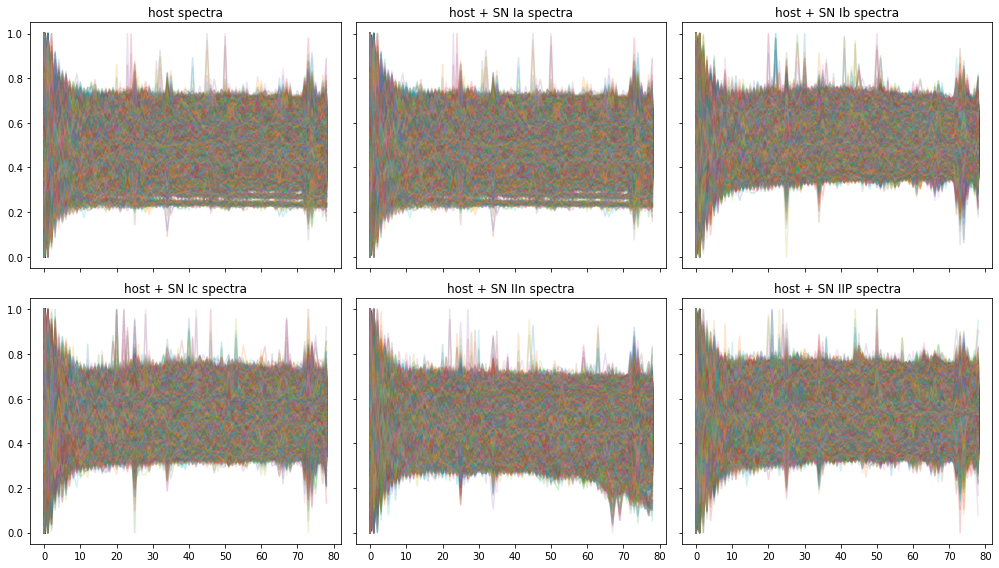

In [14]:
fig, axes = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(snia_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(sniin_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniip_flux[i], alpha=0.2) 
    
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ic spectra')
axes[4].set_title('host + SN IIn spectra')
axes[5].set_title('host + SN IIP spectra')

fig.tight_layout()

### Save the new data

In [15]:
import pickle

with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/host_flux.data', 'wb') as f:
    pickle.dump(host_flux, f)
    
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/snia_flux.data', 'wb') as f:
    pickle.dump(snia_flux, f) 
    
    
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/snib_flux.data', 'wb') as f:
    pickle.dump(snib_flux, f) 
        
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/snic_flux.data', 'wb') as f:
    pickle.dump(snic_flux, f) 
        
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/sniin_flux.data', 'wb') as f:
    pickle.dump(sniin_flux, f) 
     
with open(r'/global/homes/e/esepeku/DESI-Timedomain/Unbinned/sniip_flux.data', 'wb') as f:
    pickle.dump(sniip_flux, f) 
       